<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_FFN_FFNonMNIST_DataNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [11]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

In [12]:
# shape of the data matrix
data.shape

(20000, 785)

In [13]:
# extract labels (numbers IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


In [14]:
# # normalize the data to a range of [0 1]
# dataNorm = (data - np.min(data)) / (np.max(data) - np.min(data))

# fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# ax[0].hist(data.flatten(), 50)
# ax[0].set_xlabel('Pixel intensity values')
# ax[0].set_ylabel('Count')
# ax[0].set_title("Histogram of original data")
# ax[0].set_yscale('log')

# ax[1].hist(dataNorm.flatten(), 50)
# ax[1].set_xlabel('Pixel intensity values')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Histogram of normalized data')
# ax[1].set_yscale('log')

# plt.show()

## Create train/test groups using dataloader

In [41]:
# step 1: convert to tensor
dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).long() # long = int64

# step 2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

# train_data = (train_data - torch.min(train_data)) / (torch.max(train_data) - torch.min(train_data))

test_data = (test_data - torch.min(test_data)) / (torch.max(test_data) - torch.min(test_data))


# step 3: convert into pyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [42]:
print('Training data range %g to %g'%(torch.min(train_loader.dataset.tensors[0]), torch.max(train_loader.dataset.tensors[0])))
print('Test data range %g to %g'%(torch.min(test_loader.dataset.tensors[0]), torch.max(test_loader.dataset.tensors[0])))

Training data range 0 to 255
Test data range 0 to 1


In [43]:
# check all variables in workspace
%whos

Variable                 Type             Data/Info
---------------------------------------------------
DataLoader               type             <class 'torch.utils.data.dataloader.DataLoader'>
F                        module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset            type             <class 'torch.utils.data.dataset.TensorDataset'>
X                        Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
ax                       ndarray          2: 2 elems, type `object`, 16 bytes
batchsize                int              32
createTheMNISTNet        function         <function createTheMNISTNet at 0x7f8f1ea68050>
data                     ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm                 ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT                    Tensor           tensor([[0., 0., 0.,  ...<

## Create the DL model

In [44]:
# create a class for the model

def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ## input layer
            self.input = nn.Linear(784, 64)

            ## hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ## output layer
            self.output = nn.Linear(32, 10)
        
        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return torch.log_softmax(self.output(x), axis=1)

        
    net = mnistNet()

    # loss function 
    lossfun = nn.NLLLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

In [45]:
# test the model with one batch
net, lossfun, optimizer = createTheMNISTNet()

X, y = iter(train_loader).next()
yHat = net(X)
# value s are log-probability of each number (0-9)
print(yHat.shape)
# now let's compute the loss
loss = lossfun(yHat, y)
print(' ')
print('Loss: ')
print(loss)

torch.Size([32, 10])
 
Loss: 
tensor(4.0884, grad_fn=<NllLossBackward0>)


In [46]:
def function2trainTheModel():

    # number of epochs
    numepochs = 60

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y 
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric) 
            batchAcc.append(accuracyPct) 

        # end of batch loop

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        yHat = net(X)

        # compare the following really lon gline of code the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs
    
    # function output
    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [47]:
trainAcc, testAcc, losses, net = function2trainTheModel()

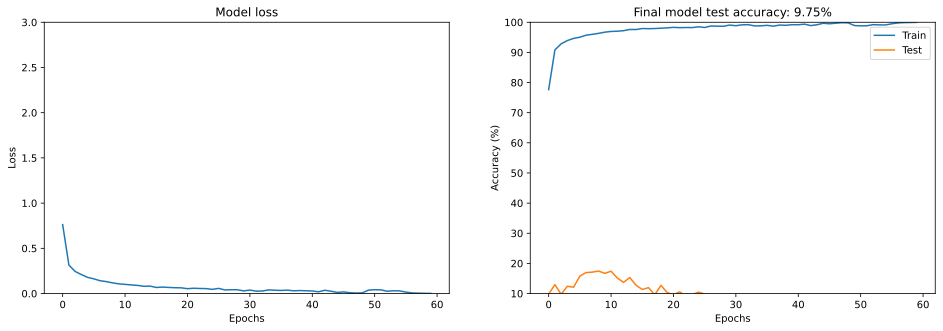

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].set_ylim([10, 100])
ax[1].legend()

plt.show()

## Inspect the results in more detail

In [49]:
# run the model through for the test data
X, y = next(iter(test_loader))
predictions = net(X).detach()

In [50]:
torch.exp(predictions)

tensor([[0.0837, 0.0983, 0.1115,  ..., 0.0891, 0.1320, 0.0821],
        [0.0831, 0.0946, 0.0923,  ..., 0.0868, 0.1577, 0.0947],
        [0.0756, 0.1032, 0.0905,  ..., 0.1055, 0.1319, 0.1037],
        ...,
        [0.0819, 0.0947, 0.0892,  ..., 0.0901, 0.1378, 0.1052],
        [0.0855, 0.0923, 0.0942,  ..., 0.0998, 0.1349, 0.0999],
        [0.1004, 0.0860, 0.0977,  ..., 0.0826, 0.1348, 0.0944]])

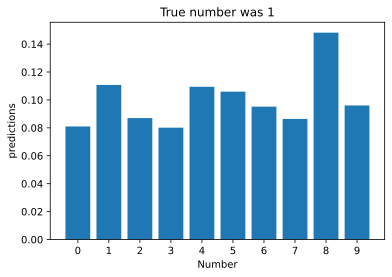

In [51]:
# Evidence for all numbers from one sample
sample2show = 323

plt.bar(range(10), torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('predictions')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[   0    2    4 ... 1997 1998 1999]


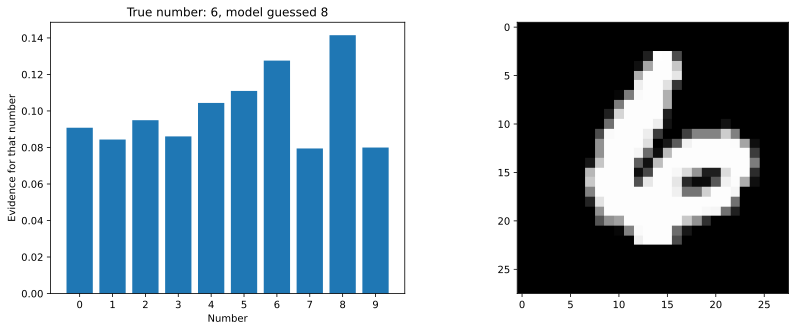

In [52]:
# find the errors
errors = np.where(torch.max(predictions, axis=1)[1] != y)[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 4

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'%(y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2show], :], (28, 28)), cmap='gray')

plt.show()